In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
import numpy as np
from collections import deque, namedtuple
import gym

In [2]:
from actor import Actor
from critic import Critic

In [3]:
env = gym.make('Pendulum-v0')

In [4]:
Experience = namedtuple('Experience', 'obs,action,reward,next_obs,done'.split(','))

In [5]:
class SAC:
    def __init__(self, env,
                 gamma=0.99,
                 num_episodes=1000, #change back to 1000
                 replay_buffer_capacity=10000,
                 batch_size=256,
                 tau=0.005,
                training_steps_per_episode=16):
        # Misc.
        self.env=env
        self.gamma=gamma
        self.log_alpha=tf.Variable(0.0)
        self.alpha = tfp.util.DeferredTensor(self.log_alpha, tf.exp)
        self.target_entropy=-1.0 #since target_entropy= -dim(action_space)
        self.tau=tau
        self.num_episodes=num_episodes
        self.replay_buffer=deque(maxlen=replay_buffer_capacity)
        self.batch_size=batch_size
        self.training_steps_per_episode=training_steps_per_episode
        # Instantiate Actor, Critics, and Target networks
        self.actor=Actor(action_scale=env.action_space.high[0])
        self.critic1=Critic()
        self.critic2=Critic()
        self.target1=Critic()
        self.target2=Critic()
        self.target1.set_weights(self.critic1.get_weights())
        self.target2.set_weights(self.critic2.get_weights())
        # Instantiate loss fxns, optimizers
        self.critic1_loss=tf.keras.losses.Huber()
        self.critic2_loss=tf.keras.losses.Huber()
        self.critic1_optimizer=keras.optimizers.Adam(learning_rate=0.003, beta_1=0.9, beta_2 = 0.999)
        self.critic2_optimizer=keras.optimizers.Adam(learning_rate=0.003, beta_1=0.9, beta_2 = 0.999)
        self.actor_optimizer=keras.optimizers.Adam(learning_rate=0.003, beta_1=0.9, beta_2 = 0.999) 
        self.alpha_optimizer=keras.optimizers.Adam(learning_rate=0.003, beta_1=0.9, beta_2 = 0.999) 
        # Containers for logging
        self.rolling_mean_episodic_rewards=[]
        self.episodic_rewards = deque(maxlen=50)
        self.critic1_losses = []
        self.critic2_losses = []
        self.actor_losses = []
        self.alpha_losses = []
    
    def _select_action(self, obs, deterministic=False):
        mu, action, _ = self.actor.predict(obs[np.newaxis])
        if deterministic:
            return mu[0]
        else:
            return action[0]
    
    def _sample_experiences(self):
        indices = np.random.randint(low=0, high=len(self.replay_buffer) -1, size=self.batch_size)
        batch = [self.replay_buffer[index] for index in indices]
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        for experience in batch:
            states.append(experience.obs)
            actions.append(experience.action)
            rewards.append(experience.reward)
            next_states.append(experience.next_obs)
            dones.append(experience.done)
        return np.array(states), np.array(actions), np.array(rewards).reshape(self.batch_size,1), np.array(next_states), np.array(dones).reshape(self.batch_size,1)
   
    def _compute_actor_loss(self, states):
        _, actions, log_probs = self.actor(states)
        log_probs=tf.reshape(log_probs, (self.batch_size,1))
        q1 = self.critic1((states, actions))
        q2 = self.critic2((states, actions))
        q_min = tf.minimum(q1, q2)
        actor_loss = tf.reduce_mean(self.alpha*log_probs - q_min)
        return actor_loss

    def _compute_critic_losses(self, states, actions, rewards, next_states, dones):
        q1 = self.critic1((states, actions))
        q2 = self.critic2((states, actions))
        next_state_mus, next_state_actions, next_state_log_probs = self.actor(next_states)  
        next_state_log_probs = tf.reshape(next_state_log_probs, (self.batch_size,1))
        q1_target = self.target1((next_states, next_state_actions))
        q2_target = self.target2((next_states, next_state_actions))
        min_q_target = tf.minimum(q1_target, q2_target) # TD3 trick       
        soft_q_target = tf.stop_gradient(rewards +(self.gamma*(1-dones)*(min_q_target - self.alpha*next_state_log_probs))) # not sure if i need tf.stop_gradient()
        critic1_loss = self.critic1_loss(soft_q_target, q1) 
        critic2_loss = self.critic2_loss(soft_q_target, q2) 
        return critic1_loss, critic2_loss
    
    def _polyak_average_target_weights(self):
        critic1_weights = self.critic1.get_weights()
        target1_weights = self.target1.get_weights()
        new1_weights = [((1-self.tau)*target + (self.tau*critic)) for target, critic in zip(target1_weights, critic1_weights)]
        self.target1.set_weights(new1_weights)
        
        critic2_weights = self.critic2.get_weights()
        target2_weights = self.target2.get_weights()
        new2_weights = [((1-self.tau)*target + (self.tau*critic)) for target, critic in zip(target2_weights, critic2_weights)]
        self.target2.set_weights(new2_weights)
        
    def _compute_alpha_loss(self, states):
        _,_,log_probs = self.actor(states)
        log_probs=tf.reshape(log_probs, (self.batch_size,1))
        alpha_losses = -1.0*(self.alpha * tf.stop_gradient(log_probs + self.target_entropy))
        mean_alpha_loss = tf.reduce_mean(alpha_losses)
        return mean_alpha_loss
    
    def _training_step(self):
        # Sample experiences and perform grad descent on critics, actor; Update target networks via polyak averaging
        states, actions, rewards, next_states, dones = self._sample_experiences()
        '''Critic Updates'''
        # Update weights of critic1
        with tf.GradientTape() as tape:
            critic1_loss, _ = self._compute_critic_losses(states, actions, rewards, next_states, dones)
        critic1_grads = tape.gradient(critic1_loss, self.critic1.trainable_variables)
        self.critic1_optimizer.apply_gradients(zip(critic1_grads, self.critic1.trainable_variables))
        # Update weights of critic2
        with tf.GradientTape() as tape:
            _ , critic2_loss = self._compute_critic_losses(states, actions, rewards, next_states, dones)
        critic2_grads = tape.gradient(critic2_loss, self.critic2.trainable_variables)
        self.critic2_optimizer.apply_gradients(zip(critic2_grads, self.critic2.trainable_variables))
        # Track critic1 and critic2 losses for debugging
        self.critic1_losses.append(critic1_loss.numpy())
        self.critic2_losses.append(critic2_loss.numpy())     
        '''Actor Update'''
        with tf.GradientTape() as tape:
            actor_loss = self._compute_actor_loss(states)
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))
        self.actor_losses.append(actor_loss.numpy())
        '''Alpha Update'''
        with tf.GradientTape() as tape:
            alpha_loss = self._compute_alpha_loss(states)
        alpha_grads = tape.gradient(alpha_loss, [self.log_alpha])
        self.alpha_optimizer.apply_gradients(zip(alpha_grads, [self.log_alpha]))
        self.alpha_losses.append(alpha_loss.numpy())
        '''Target Network Update'''
        self._polyak_average_target_weights()


    def main_training_loop(self):
        """(i) Agent generates experiences that are added to replay buffer. 
        (ii) Sample experiences from replay buffer to update critics and actor via grad descent.
        (iii) Update target networks using polyak averaging. """
        for episode in range(self.num_episodes):
            obs=self.env.reset()
            done=False
            single_episode_rewards=[]
            while not done:
                action=self._select_action(obs)
                next_obs, reward, done, _ = self.env.step(action)
#                 print(next_obs)
                experience=Experience(obs=obs, action=action, reward=reward, next_obs=next_obs, done=done)
                self.replay_buffer.append(experience)
                obs=next_obs
                single_episode_rewards.append(reward)
                if done:
                    self.episodic_rewards.append(sum(single_episode_rewards))
                    break # this isn't necessary fyi
            if episode > 20:
                for _ in range(self.training_steps_per_episode):
                    self._training_step()
                mean_reward = sum(self.episodic_rewards)/50
                self.rolling_mean_episodic_rewards.append(mean_reward)
                print('episode: {}\t rolling episodic reward: {}'.format(episode, mean_reward))

        
        
        
        
        
        

In [6]:
sac = SAC(env=env)

In [7]:
sac.main_training_loop()

episode: 21	 rolling episodic reward: -643.8535300022235
episode: 22	 rolling episodic reward: -663.8182472815736
episode: 23	 rolling episodic reward: -697.4929047355658
episode: 24	 rolling episodic reward: -728.9816556126124
episode: 25	 rolling episodic reward: -755.6488816056147
episode: 26	 rolling episodic reward: -781.8721747115255
episode: 27	 rolling episodic reward: -808.4697082487219
episode: 28	 rolling episodic reward: -827.8953351495406
episode: 29	 rolling episodic reward: -846.1617974077526
episode: 30	 rolling episodic reward: -863.8899956956776
episode: 31	 rolling episodic reward: -897.4771570673063
episode: 32	 rolling episodic reward: -925.4769884714971
episode: 33	 rolling episodic reward: -953.9395129400934
episode: 34	 rolling episodic reward: -979.1229112728212
episode: 35	 rolling episodic reward: -1005.5826232467733
episode: 36	 rolling episodic reward: -1036.1332337602248
episode: 37	 rolling episodic reward: -1072.5395167819788
episode: 38	 rolling episodi

In [8]:
import matplotlib.pyplot as plt

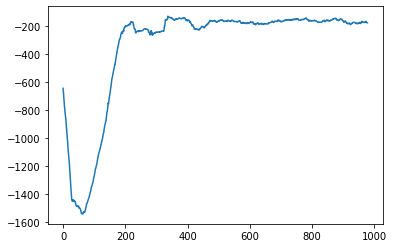

In [9]:
plt.plot(sac.rolling_mean_episodic_rewards)